# 0. Imports 

In [4]:
#!pip install --upgrade TensorFlow
#!pip install --upgrade tensorflow_probability
#!pip install --upgrade seaborn


In [5]:
# Auto reload
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2


# Data manipulation libraries

# Neural Networks and proba
tfd = tfp.distributions

# Plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

# Reproducible Results
random_seed = 2022
tf.random.set_seed(random_seed)
rng = np.random.RandomState(random_seed)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Data Generation

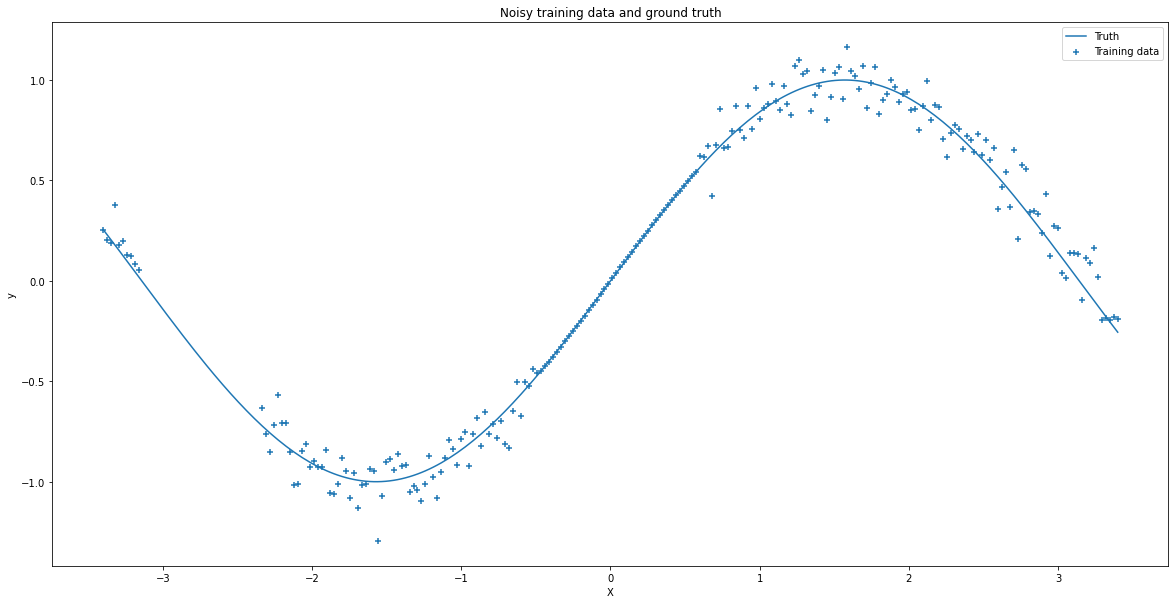

In [6]:
def f(x):
    return np.sin(x).ravel()


def modify_uncertainty(x, y, sigma):

    # aleatric uncertainty
    epsilon = (rng.randn(*x.shape) * sigma).ravel()

    # low aleatric uncertainty
    epsilon[110:150] = 0
    y = y + epsilon

    # high epsitemic uncertainty
    for i in range(30):
        x = np.delete(x, 10)
        y = np.delete(y, 10)

    return x, y


train_size = 256
noise = 0.1

X_true = np.linspace(-3.4, 3.4, train_size).reshape(-1, 1)
y_true = f(X_true)

X, y = modify_uncertainty(X_true, y_true, noise)

plt.scatter(X, y, marker='+', label='Training data')
plt.plot(X_true, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()


# 2. Simple Model 

### 2.1. Building the model

In [7]:
hidden_units = [8]

inputs = tf.keras.layers.Input(name='inputs', shape=(1,), dtype=tf.float32)

# Create hidden layers with deterministic weights using the Dense layer.
layer = inputs
for units in hidden_units:
    layer = tf.keras.layers.Dense(units, activation='relu')(layer)

# The output is deterministic: a single point estimate.
outputs = tf.keras.layers.Dense(units=1)(layer)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)


In [9]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 8)                 16        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


### 2.2. Fitting the model

In [10]:
num_epochs = 250
print("Start training the model...")

H = model.fit(X, y, epochs=num_epochs, verbose=0)
print("Model training finished.")


Start training the model...
Model training finished.


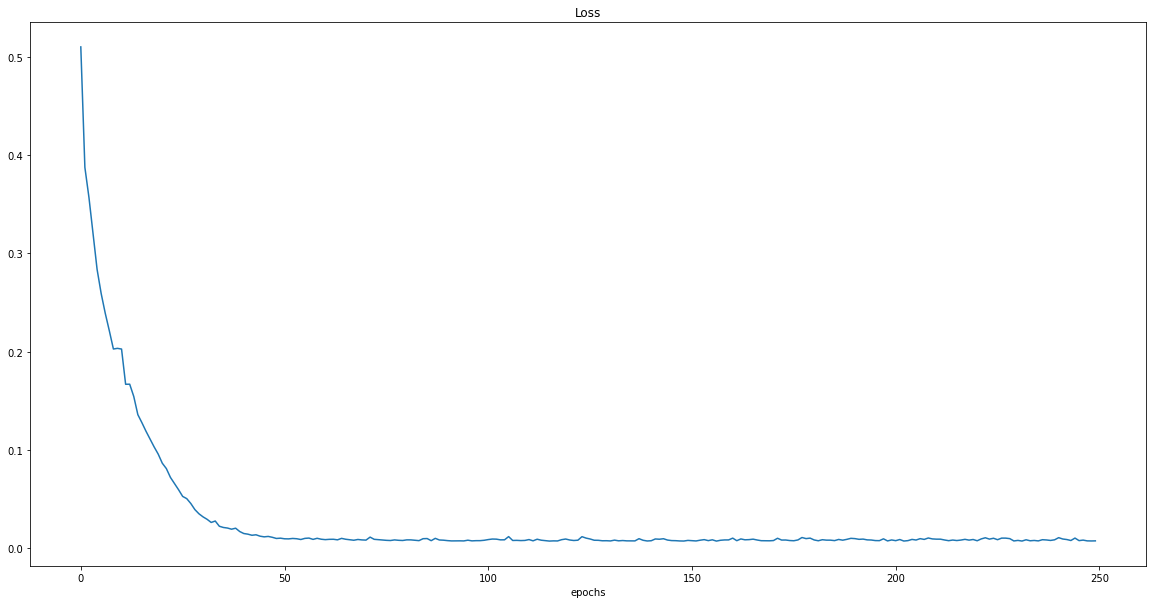

In [11]:
plt.plot(H.history['loss'])
plt.title('Loss')
plt.xlabel('epochs')
plt.show()


### 2.3. Plotting results

8/8 [==============================] - 0s 2ms/step


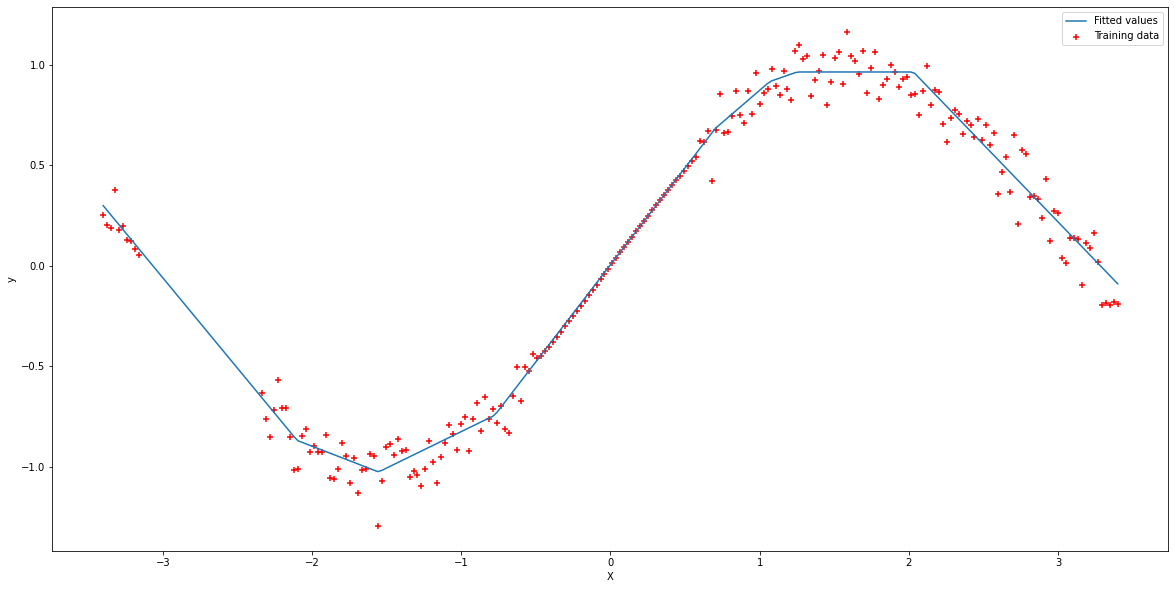

In [12]:
plt.plot(X, model.predict(X), label='Fitted values')
plt.scatter(X, y, marker='+', label='Training data', color='r')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


# 3. Bayesian Neural Network

$$\underbrace{\frac{1}{T} \sum_{t=1}^{T} \mathbf{diag}\left(\hat{\sigma}_{t}^{2}\right)}_{\text {aleatoric }}+\underbrace{\frac{1}{T} \sum_{t=1}^{T}\left(\hat{\mu}_{t}-\bar{\mu}\right)^{\otimes 2}}_{\text {epistemic }}$$

## 3.1 Aleatoric uncertainty

$$\frac{1}{T} \sum_{t=1}^{T} \mathbf{diag}\left(\hat{\sigma}_{t}^{2}\right)$$

### 3.1.1. Building the model

In [13]:
hidden_units = [8]

inputs = tf.keras.layers.Input(name='inputs', shape=(1,), dtype=tf.float32)

# Create hidden layers with deterministic weights using the Dense layer (No epistemic uncertainty to model)
layer = inputs
for units in hidden_units:
    layer = tf.keras.layers.Dense(units, activation='relu')(layer)

# This time, the output is a distribution (Normal is this example)
distribution_params = tf.keras.layers.Dense(units=2)(layer)
outputs = tfp.layers.IndependentNormal(1)(distribution_params)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [14]:
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1)]               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 16        
                                                                 
 dense_3 (Dense)             (None, 2)                 18        
                                                                 
 independent_normal (Indepen  ((None, 1),              0         
 dentNormal)                  (None, 1))                         
                                                                 
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


### 3.1.2. Fitting the model

In [15]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)


num_epochs = 1000

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=negative_loglikelihood,
    metrics=[tf.keras.metrics.RootMeanSquaredError()],

)

print("Start training the model...")
H = model.fit(X, y, epochs=num_epochs, verbose=0)
print("Model training finished.")


Start training the model...
Model training finished.


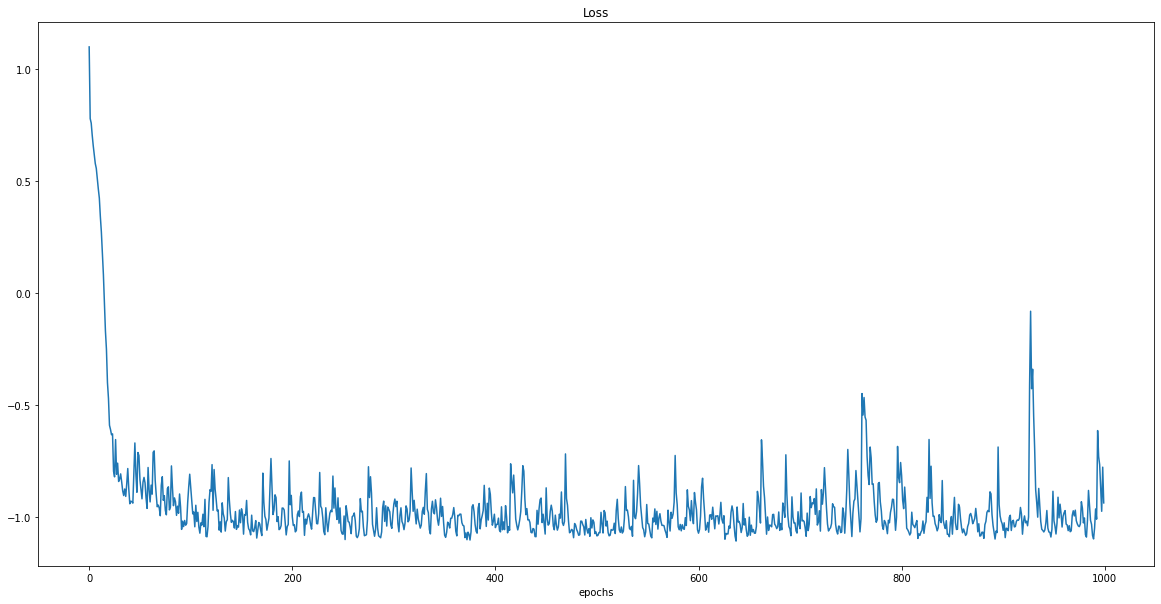

In [16]:
plt.plot(H.history['loss'])
plt.title('Loss')
plt.xlabel('epochs')
plt.show()


### 3.1.3. Uncertainty and Plotting results

With only Aleatoric uncertainty to model, we don't have weight uncertainty and only one output, so :

$$\frac{1}{T} \sum_{t=1}^{T} \mathbf{diag}\left(\hat{\sigma}_{t}^{2}\right) =\hat{\sigma}^{2}$$

In [17]:
y_pred = model(X)


In [18]:
y_pred_mean = y_pred.mean().numpy()


In [19]:
y_pred_std = y_pred.stddev().numpy()


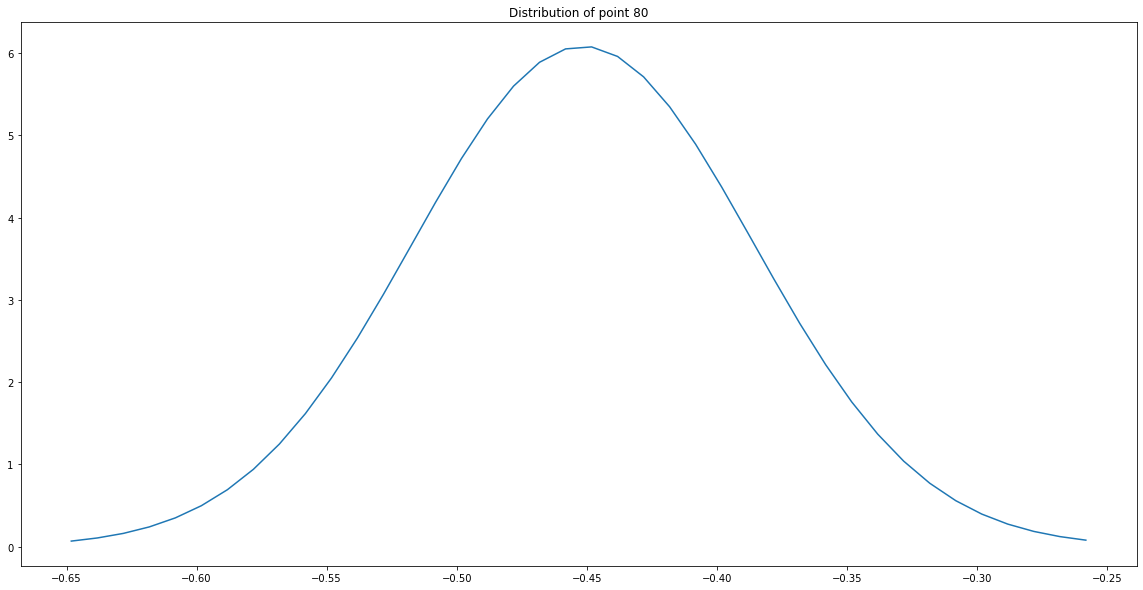

In [20]:
i = 80

x_axis = np.arange(y_pred_mean[i]-3*y_pred_std[i],
                   y_pred_mean[i]+3*y_pred_std[i], 0.01)
plt.plot(x_axis, norm.pdf(x_axis, y_pred_mean[i], y_pred_std[i])
         )

plt.title('Distribution of point {}'.format(i))
plt.show()


In [21]:
y_pred_alea_uncertainy = y_pred_std**2


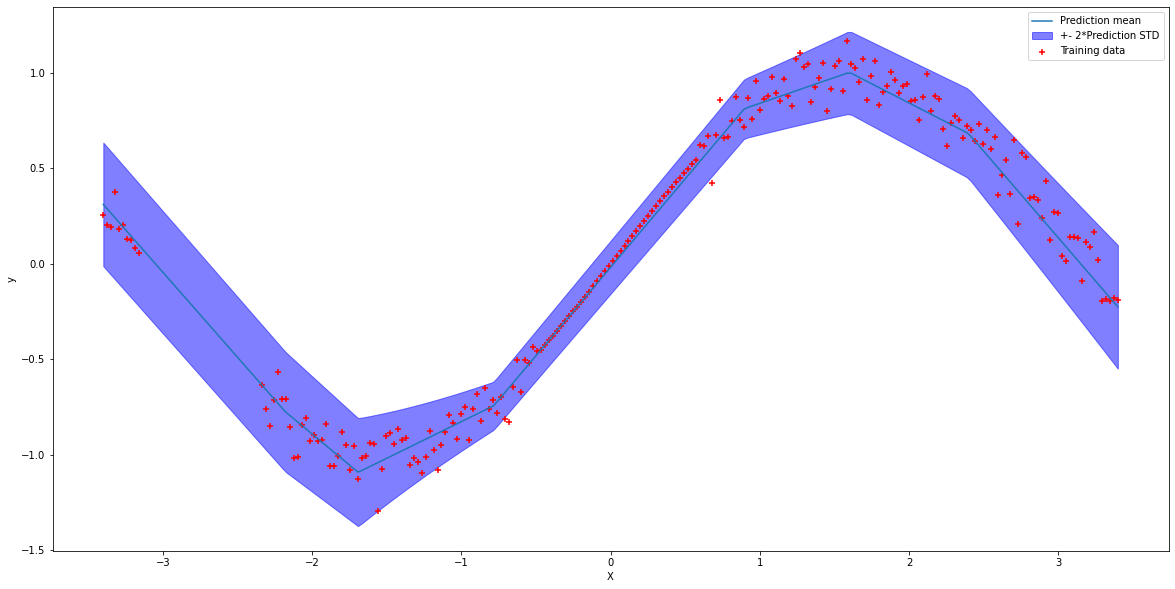

In [22]:
plt.plot(X, y_pred_mean, label='Prediction mean')

plt.fill_between(X, (y_pred_mean-2*y_pred_std).flatten(),
                 (y_pred_mean+2*y_pred_std).flatten(),
                 label='+- 2*Prediction STD',
                 color='b', alpha=.5)

plt.scatter(X, y, marker='+', label='Training data', color='r')

plt.xlabel('X')
plt.ylabel('y')
plt.legend()

plt.show()


## 3.2 Epistemic uncertainty

### 3.2.3. Building the model

$$\frac{1}{T} \sum_{t=1}^{T}\left(\hat{\mu}_{t}-\bar{\mu}\right)^{\otimes 2}$$

In this case, to model the espistemic uncertainty, weights are modeled distributions.


In addition to that, because we don't have to consider $\sigma$, we could use a single point output (not a distribution) and use MSE loss function.

$$\hat y_t =  \hat{\mu}_{t}$$ 

In [23]:
# Normal prior
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])


# Normal posetrior
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model


"""def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])"""

"""#Normal prior - Not trainable
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model"""


'#Normal prior - Not trainable\ndef prior(kernel_size, bias_size, dtype=None):\n    n = kernel_size + bias_size\n    prior_model = tf.keras.Sequential(\n        [\n            tfp.layers.DistributionLambda(\n                lambda t: tfp.distributions.MultivariateNormalDiag(\n                    loc=tf.zeros(n), scale_diag=tf.ones(n)\n                )\n            )\n        ]\n    )\n    return prior_model'

In [24]:
hidden_units = [8]

inputs = tf.keras.layers.Input(
    name='inputs', shape=(1,), dtype=tf.float32
)

layer = inputs
for units in hidden_units:
    layer = tfp.layers.DenseVariational(units, posterior, prior_trainable,
                                        kl_weight=1/X.shape[0], activation='relu')(layer)

# The output is deterministic: a single point estimate.
outputs = tf.keras.layers.Dense(units=1)(layer)
model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [25]:
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1)]               0         
                                                                 
 dense_variational (DenseVar  (None, 8)                168       
 iational)                                                       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


### 3.2.2. Fitting the model

In [26]:
mse_loss = tf.keras.losses.MeanSquaredError()
num_epochs = 1000

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=mse_loss,
    metrics=[tf.keras.metrics.RootMeanSquaredError()],

)

print("Start training the model...")
H = model.fit(X, y, epochs=num_epochs, verbose=0)
print("Model training finished.")


Start training the model...
Model training finished.


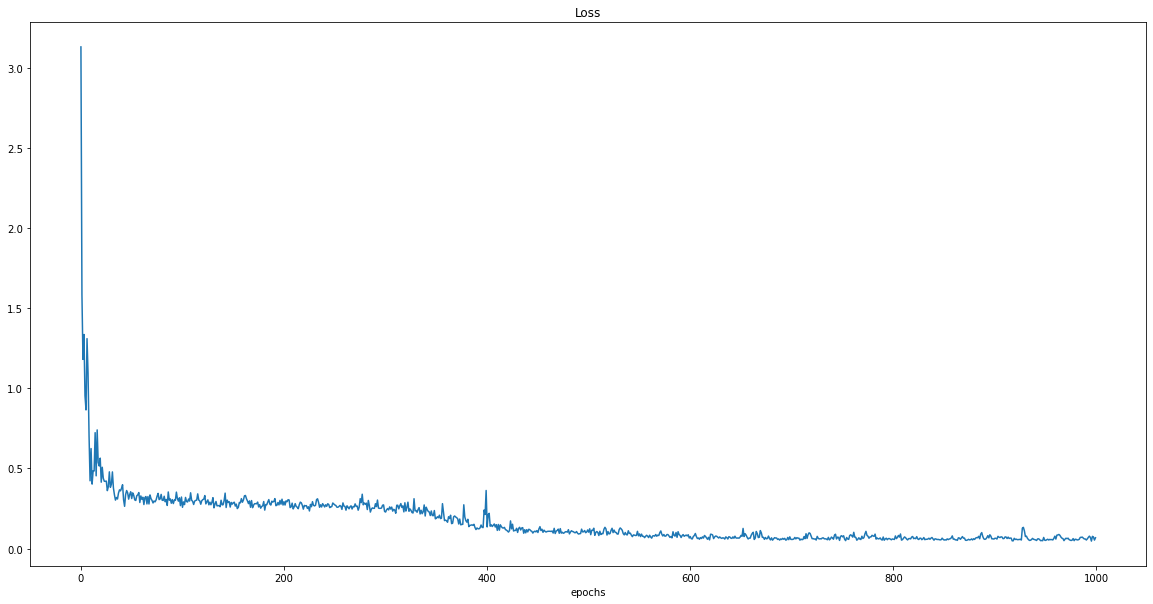

In [27]:
plt.plot(H.history['loss'])
plt.title('Loss')
plt.xlabel('epochs')
plt.show()


### 3.2.3. Uncertainty and Plotting results

$$\frac{1}{T} \sum_{t=1}^{T}\left(\hat{\mu}_{t}-\bar{\mu}\right)^{\otimes 2}$$

$$ = \frac{1}{T} \sum_{t=1}^{T}\left(\hat{y}_{t}-\bar{y}\right)^{2} = \mathbf{var}\space \hat{y}$$

In [28]:
T = 100

y_pred = []
for i in range(T):
    y_pred.append(model.predict(X))

y_pred = np.array(y_pred)


8/8 [==============================] - 0s 1ms/step


<AxesSubplot:ylabel='Count'>

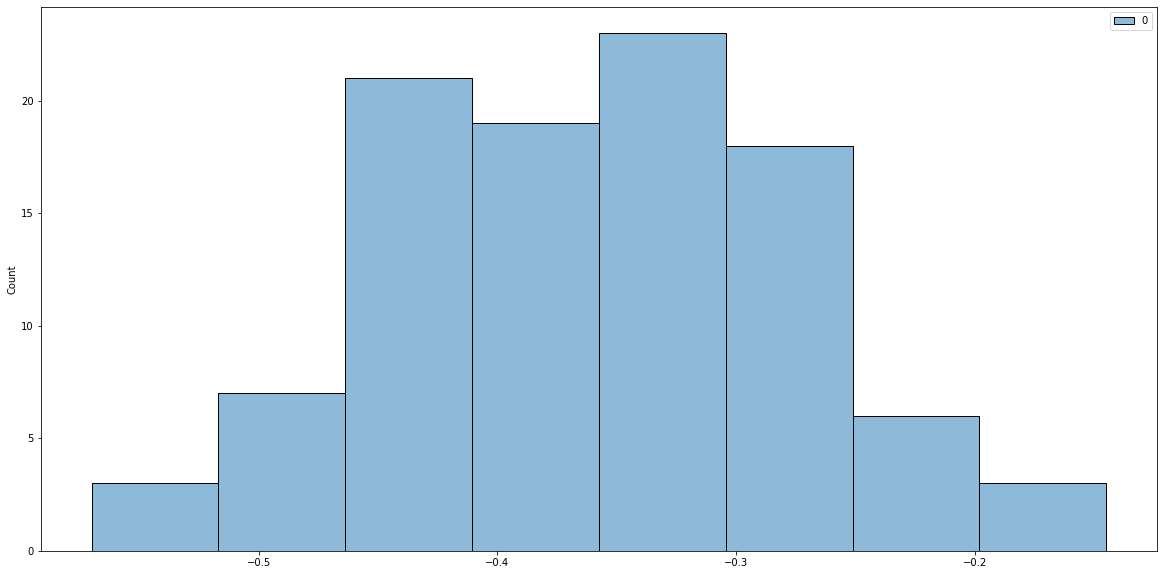

In [29]:
i = 80

sns.histplot(y_pred[:, i])


In [30]:
y_pred_epis_uncertainy = y_pred.var(axis=1)


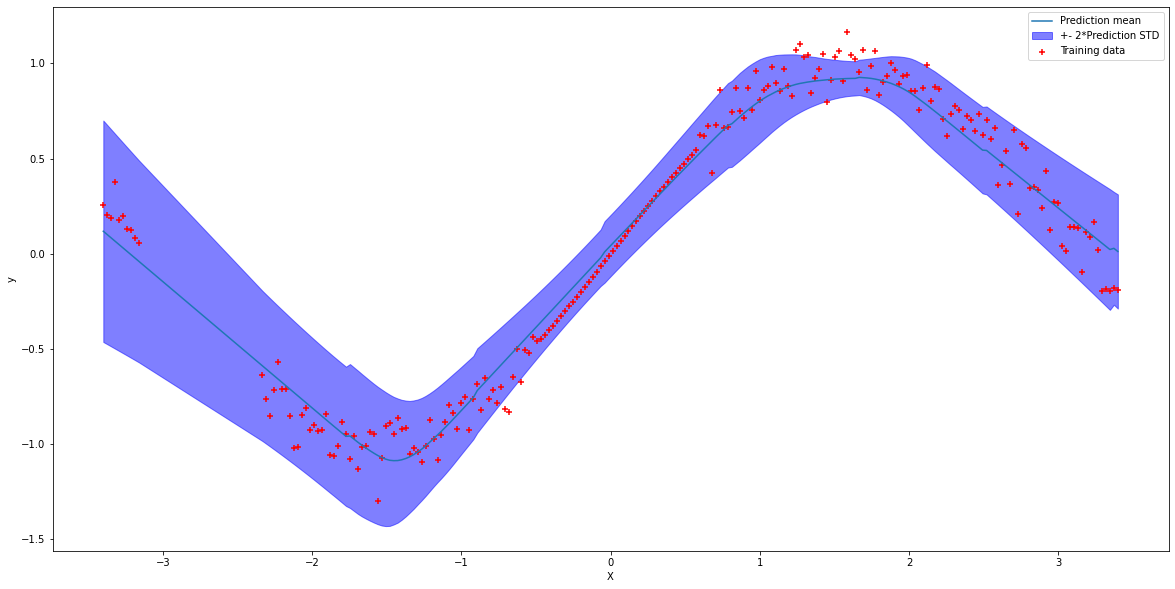

In [31]:
plt.plot(X, y_pred.mean(axis=0), label='Prediction mean')
plt.fill_between(X.flatten(), (y_pred.mean(axis=0)-2*y_pred.std(axis=0)).flatten(),
                 (y_pred.mean(axis=0)+2*y_pred.std(axis=0)).flatten(),
                 label='+- 2*Prediction STD',
                 color='b', alpha=.5)
plt.scatter(X, y, marker='+', label='Training data', color='r')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


## 3.3 Epistemic & Aleatoric uncertainty

$$\underbrace{\underbrace{\frac{1}{T} \sum_{t=1}^{T} \mathbf{diag}\left(\hat{\sigma}_{t}^{2}\right)}_{\text {aleatoric }}+\underbrace{\frac{1}{T} \sum_{t=1}^{T}\left(\hat{\mu}_{t}-\bar{\mu}\right)^{\otimes 2}}_{\text {epistemic }}}_{\text {uncertainty }}$$

### 3.3.1. Building the model

In [32]:
hidden_units = [8]

inputs = tf.keras.layers.Input(
    name='inputs', shape=(1,), dtype=tf.float32
)

layer = inputs
for units in hidden_units:
    layer = tfp.layers.DenseVariational(units, posterior, prior_trainable,
                                        kl_weight=1/X.shape[0], activation='relu')(layer)

# The output is a distribution (Normal is this example)
distribution_params = tf.keras.layers.Dense(units=2)(layer)
outputs = tfp.layers.IndependentNormal(1)(distribution_params)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [33]:
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1)]               0         
                                                                 
 dense_variational_1 (DenseV  (None, 8)                168       
 ariational)                                                     
                                                                 
 dense_5 (Dense)             (None, 2)                 18        
                                                                 
 independent_normal_1 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 186
Trainable params: 186
Non-trainable params: 0
_________________________________________________________________


### 3.3.2. Fitting the model

In [34]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)


num_epochs = 1000

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=negative_loglikelihood,
    metrics=[tf.keras.metrics.RootMeanSquaredError()],

)

print("Start training the model...")
H = model.fit(X, y, epochs=num_epochs, verbose=0)
print("Model training finished.")


Start training the model...
Model training finished.


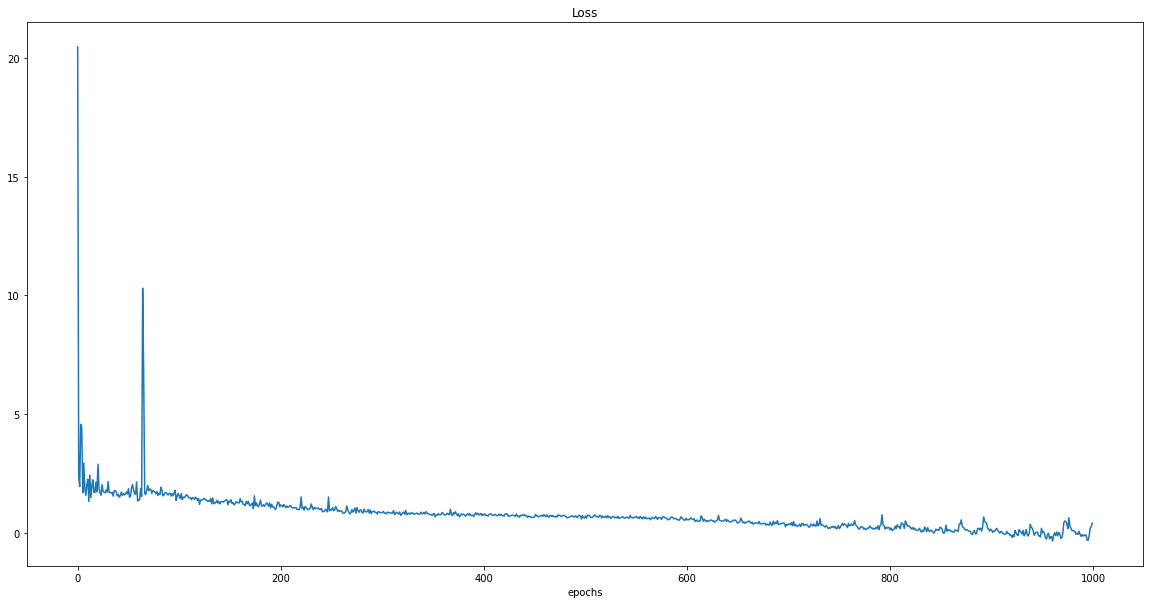

In [35]:
plt.plot(H.history['loss'])
plt.title('Loss')
plt.xlabel('epochs')
plt.show()


### 3.3.3. Uncertainty and Plotting results

$$\underbrace{\underbrace{\frac{1}{T} \sum_{t=1}^{T} \mathbf{diag}\left(\hat{\sigma}_{t}^{2}\right)}_{\text {aleatoric }}+\underbrace{\frac{1}{T} \sum_{t=1}^{T}\left(\hat{\mu}_{t}-\bar{\mu}\right)^{\otimes 2}}_{\text {epistemic }}}_{\text {uncertainty }}$$

In [36]:
T = 100

y_pred = []
for i in range(T):
    y_pred.append(model(X))

y_pred = np.array(y_pred)


In [37]:
sigma_2 = []
mu = []
for t in range(T):
    sigma_2 += [y_pred[t].stddev().numpy()**2]
    mu += [y_pred[t].mean().numpy()]

sigma_2 = np.array(sigma_2)
mu = np.array(mu)

y_pred_epis_uncertainy = mu.var(axis=0).flatten()

y_pred_alea_uncertainy = sigma_2.mean(axis=0).flatten()

uncertainty = y_pred_alea_uncertainy + y_pred_epis_uncertainy


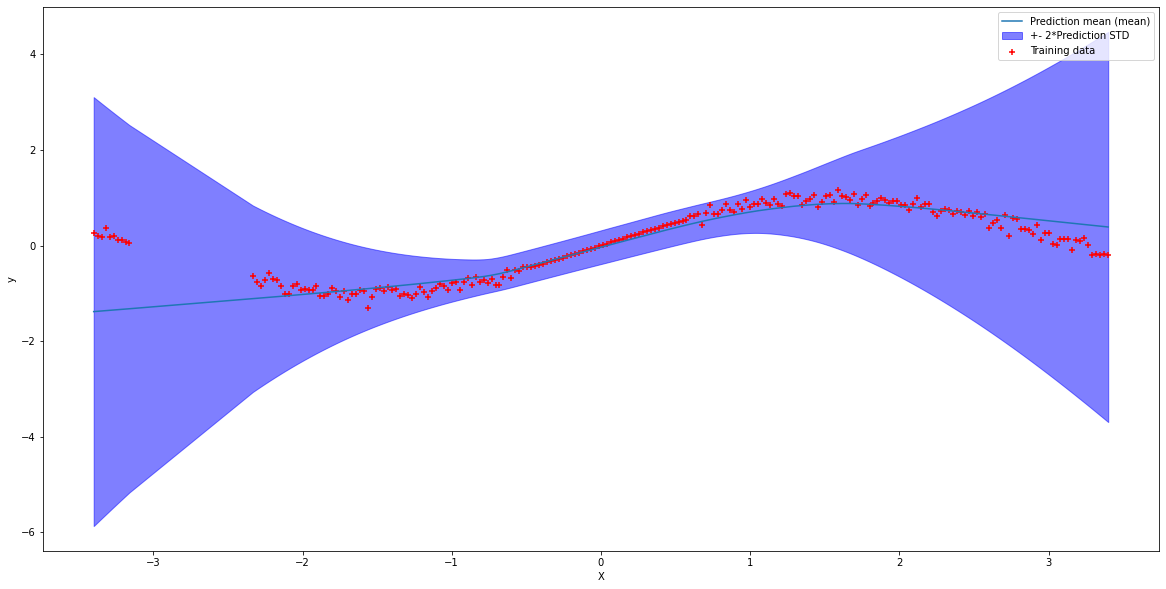

In [38]:
plt.plot(X, mu.mean(axis=0), label='Prediction mean (mean)')

uncertainty_std = np.sqrt(uncertainty)

plt.fill_between(X.flatten(), (mu.mean(axis=0).flatten()-2*uncertainty_std).flatten(),
                 (mu.mean(axis=0).flatten()+2*uncertainty_std).flatten(),
                 label='+- 2*Prediction STD',
                 color='b', alpha=.5)

plt.scatter(X, y, marker='+', label='Training data', color='r')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

plt.show()
